In [1]:
import json
import ee
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import os
#from config import config, delete_temp
#from load_gdrive import get_service, get_uploaded_file, load_gdrive

#authenticate

#ee.Authenticate(force=True)
ee.Authenticate


ee.Initialize(project='gee-trial-payg')

In [2]:
import ee
import pandas as pd
from shapely import wkt
from shapely.geometry import Polygon
import pyproj

def get_polygon_from_df(row):
    """
    Extracts the polygon from a DataFrame row and converts it to an EE Geometry.

    Parameters:
    - row: A row from the DataFrame containing 'polygon_wkt'

    Returns:
    - ee.Geometry.Polygon object
    """
    polygon_wkt = row["polygon_wkt"]  # Extract the WKT string
    shapely_polygon = wkt.loads(polygon_wkt)  # Convert WKT to Shapely polygon
    
    # Convert polygon to a projected coordinate system (e.g., UTM)
    projected_polygon = shapely_polygon.buffer(0)  # Ensure valid geometry
    project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

    # Transform coordinates to metric projection
    projected_coords = [project.transform(x, y) for x, y in shapely_polygon.exterior.coords]
    projected_polygon = Polygon(projected_coords)  # Create new polygon in meters

    # Calculate area in square meters
    area_m2 = projected_polygon.area  
    print(f"Area in square meters: {area_m2}")

    # If area is smaller than 500 sqm, expand to a circle of 1000 sqm
    if area_m2 < 500:
        centroid = projected_polygon.centroid  # Get centroid
        new_radius = (1000 / 3.14159) ** 0.5  # Compute radius for a 1000 sqm circle
        projected_polygon = centroid.buffer(new_radius)  # Create a circular buffer

        print(f"Area adjusted to approximately 1000 sqm using a circular buffer.")

    # Transform back to lat/lon (EPSG:4326)
    reverse_project = pyproj.Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    final_coords = [reverse_project.transform(x, y) for x, y in projected_polygon.exterior.coords]

    return ee.Geometry.Polygon(final_coords)  # Convert to EE Geometry

In [3]:
import ee
import pandas as pd
from scipy.signal import savgol_filter

def get_sar_time_series(farmid, polygon, start_date, end_date):
    """
    Computes a suite of vegetation indices (NDVI, EVI, NDWI, SAVI, GNDVI, NDRE, MSAVI,
    OSAVI, LSWI, and EVI2) from Sentinel-2 data. Applies a cloud mask and a Savitzky–Golay
    filter to smooth NDVI and EVI time series.
    """
    # Load Sentinel-2 Surface Reflectance Harmonized collection.
    collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                  .filterBounds(polygon)
                  .filterDate(start_date, end_date)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 90)))
    
    # Cloud masking function using the QA60 band.
    def maskS2clouds(image):
        qa = image.select('QA60')
        cloudBitMask = 1 << 10  # Clouds.
        cirrusBitMask = 1 << 11  # Cirrus.
        mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
        # The reflectance values are scaled by 10000; convert to reflectance.
        return image.updateMask(mask).divide(10000).copyProperties(image, ["system:time_start"])
    
    collection = collection.map(maskS2clouds)
    
    # Function to add various vegetation indices.
    def addIndices(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        evi = image.expression(
            '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
            {'NIR': image.select('B8'),
             'RED': image.select('B4'),
             'BLUE': image.select('B2')}
        ).rename('EVI')
        ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
        savi = image.expression(
            '((NIR - RED) / (NIR + RED + L)) * (1 + L)',
            {'NIR': image.select('B8'),
             'RED': image.select('B4'),
             'L': 0.5}
        ).rename('SAVI')
        gndvi = image.normalizedDifference(['B8', 'B3']).rename('GNDVI')
        ndre = image.normalizedDifference(['B8A', 'B5']).rename('NDRE')
        msavi = image.expression(
            '(2 * NIR + 1 - sqrt(pow((2 * NIR + 1), 2) - 8 * (NIR - RED))) / 2',
            {'NIR': image.select('B8'),
             'RED': image.select('B4')}
        ).rename('MSAVI')
        osavi = image.expression(
            '(NIR - RED) / (NIR + RED + 0.16)',
            {'NIR': image.select('B8'),
             'RED': image.select('B4')}
        ).rename('OSAVI')
        lswi = image.normalizedDifference(['B8', 'B11']).rename('LSWI')
        evi2 = image.expression(
            '2.4 * ((NIR - RED) / (NIR + RED + 1))',
            {'NIR': image.select('B8'),
             'RED': image.select('B4')}
        ).rename('EVI2')
        return image.addBands([ndvi, evi, ndwi, savi, gndvi, ndre, msavi, osavi, lswi, evi2])
    
    collection_indexed = collection.map(addIndices)
    
    # Function to extract per-image mean values for each index over the polygon.
    def extract_index_data(image):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=polygon,
            scale=10,
            maxPixels=1e13
        )
        return ee.Feature(None, {
            'FarmID': farmid,  # Add farmid here.
            'date': ee.Date(image.get("system:time_start")).format("YYYY-MM-dd"),
            'NDVI': stats.get("NDVI"),
            'EVI': stats.get("EVI"),
            'NDWI': stats.get("NDWI"),
            'SAVI': stats.get("SAVI"),
            'GNDVI': stats.get("GNDVI"),
            'NDRE': stats.get("NDRE"),
            'MSAVI': stats.get("MSAVI"),
            'OSAVI': stats.get("OSAVI"),
            'LSWI': stats.get("LSWI"),
            'EVI2': stats.get("EVI2")
        })
    
    extracted_data = collection_indexed.map(extract_index_data)
    
    # Convert FeatureCollection to a list of dictionaries.
    features = extracted_data.getInfo()['features']
    data = [feat['properties'] for feat in features]
    
    df_sar = pd.DataFrame(data)
    
    # Convert 'date' to datetime and sort the DataFrame by date.
    df_sar['date'] = pd.to_datetime(df_sar['date'])
    df_sar.sort_values('date', inplace=True)
    df_sar.reset_index(drop=True, inplace=True)
    
    # Apply the Savitzky–Golay filter to smooth NDVI and EVI time series (if enough data points).
    if len(df_sar) >= 5:
        window_length = 5  # Must be odd; adjust as needed.
        polyorder = 2
        df_sar['NDVI_sg'] = savgol_filter(df_sar['NDVI'], window_length, polyorder)
        df_sar['EVI_sg'] = savgol_filter(df_sar['EVI'], window_length, polyorder)
    else:
        df_sar['NDVI_sg'] = df_sar['NDVI']
        df_sar['EVI_sg'] = df_sar['EVI']
    
    print(df_sar)
    return df_sar


In [4]:
import pandas as pd

# Load the CSV file
file_path = "output_with_WKT.csv"  # Replace with the actual file path
df = pd.read_csv(file_path)
unique_df = df.drop_duplicates(subset=["FarmID"])
start_date = '2022-01-01'
end_date = '2025-01-01'

In [5]:
print(unique_df)


      Cycle Plot No  FarmID   No    Block        Method       Variety  \
0    2022-1    AEA1    2916    1      NaN       Long CC  Srangae Sral   
2    2022-1   AEA10    2917   10      NaN  Conventional  Srangae Sral   
4    2023-1  AEA100    2918  100  Block E      Mungbean  Srangae sral   
5    2023-1  AEA101    2919  101  Block B        LongCC     Sen Kraob   
8    2023-1  AEA102    2920  102  Block D      Mungbean  Srangae sral   
..      ...     ...     ...  ...      ...           ...           ...   
252  2023-1   AEA94    3024   94  Block B      Mungbean  Srangae sral   
255  2023-1   AEA95    3025   95  Block D        LongCC  Srangae sral   
256  2023-1   AEA96    3026   96  Block C        LongCC     Sen Kraob   
257  2023-1   AEA98    3027   98  Block E      Mungbean  Srangae sral   
259  2023-2   AEA99    3028   99  Block E      Mungbean           NaN   

     Surface (ha)  Seed Quantity (kg)  Basal Fertilizer Applied?  ...  \
0            0.40                64.0             

In [6]:
import pandas as pd

df_total_result = pd.DataFrame()


for index, row in unique_df.iterrows():
#    #print(row)
    farmid = row["FarmID"]
    polygon = get_polygon_from_df(row)
    df_result = get_sar_time_series(farmid, polygon, start_date, end_date)
    df_total_result = pd.concat([df_total_result, df_result])
    print(df_total_result)
    
#df = get_sar_time_series(start_date, end_date)
print(df_total_result)

Area in square meters: 4226.506593712728
          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.067683  0.064340    2916  0.404394 -0.183937  0.054955  0.259676   
1    0.201066  0.207368    2916  0.411401 -0.198367  0.181442  0.209815   
2    0.225270  0.224735    2916  0.409592 -0.191023  0.196966  0.218853   
3    0.200884  0.203427    2916  0.389749 -0.198325  0.177534  0.204514   
4    0.221978  0.185440    2916  0.305836 -0.136535  0.160794  0.174010   
..        ...       ...     ...       ...       ...       ...       ...   
158  1.380425  0.554719    2916  0.486190  0.367937  0.505514  0.495894   
159       NaN       NaN    2916       NaN       NaN       NaN       NaN   
160       NaN       NaN    2916       NaN       NaN       NaN       NaN   
161  0.598424  0.549486    2916  0.663605  0.352079  0.539565  0.512683   
162  0.491729  0.473681    2916  0.612340  0.289948  0.449852  0.419409   

         NDVI      NDWI     OSAVI      SAVI       date   N

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.383969  0.382552    2919  0.516345  0.149245  0.351583  0.296648   
1    0.133130  0.144161    2919  0.349015 -0.136249  0.123609  0.138271   
2    0.137349  0.145378    2919  0.345085 -0.175429  0.124590  0.144185   
3    0.131243  0.138990    2919  0.332391 -0.190263  0.118969  0.145934   
4   -0.072115 -0.037820    2919 -0.005877 -0.037373 -0.031469 -0.023810   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2919       NaN       NaN       NaN       NaN   
159       NaN       NaN    2919       NaN       NaN       NaN       NaN   
160       NaN       NaN    2919       NaN       NaN       NaN       NaN   
161  0.530975  0.470348    2919  0.715233  0.382851  0.470016  0.631433   
162  0.528506  0.476887    2919  0.699857  0.415261  0.474136  0.596954   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.564391 -0.51634

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.121142  0.133365    2922  0.333418 -0.249815  0.113602  0.132537   
1    0.120535  0.133537    2922  0.333935 -0.246825  0.113695  0.130688   
2    0.121025  0.136341    2922  0.354667 -0.237273  0.116367  0.133459   
3    0.121684  0.135659    2922  0.350655 -0.237068  0.115779  0.132730   
4    0.131293  0.143983    2922  0.348793 -0.237628  0.122895  0.139519   
..        ...       ...     ...       ...       ...       ...       ...   
305  0.735260  0.658193    2922  0.799343  0.479779  0.698332  0.728589   
306  0.740603  0.659793    2922  0.798495  0.480120  0.700646  0.729368   
307  0.725768  0.654398    2922  0.757495  0.502338  0.676221  0.664721   
308  0.719658  0.658594    2922  0.765571  0.502802  0.683548  0.668804   
309  0.695404  0.425762    2922  0.396567  0.251986  0.377958  0.355259   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.173704 -0.33341

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.105357  0.102821    2925  0.295736 -0.225022  0.087831  0.108700   
1    0.065089  0.063863    2925  0.282233 -0.328938  0.054282  0.142717   
2    0.072120  0.069969    2925  0.273253 -0.326303  0.059476  0.131128   
3    0.074911  0.074972    2925  0.277922 -0.323661  0.063742  0.134999   
4         NaN       NaN    2925       NaN       NaN       NaN       NaN   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2925       NaN       NaN       NaN       NaN   
159       NaN       NaN    2925       NaN       NaN       NaN       NaN   
160       NaN       NaN    2925       NaN       NaN       NaN       NaN   
161  0.600459  0.533658    2925  0.744042  0.433966  0.543637  0.665867   
162  0.585385  0.528806    2925  0.699532  0.434787  0.529266  0.592827   

         NDVI      NDWI     OSAVI      SAVI       date  NDVI_sg  EVI_sg  
0    0.179568 -0.295736  

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.331776  0.331393    2928  0.522504  0.071575  0.302953  0.299431   
1    0.171991  0.186205    2928  0.399091 -0.136101  0.161279  0.175507   
2    0.184803  0.196292    2928  0.392828 -0.182101  0.169895  0.181889   
3    0.160795  0.170025    2928  0.377034 -0.193346  0.146957  0.178593   
4    0.108677  0.110262    2928  0.243437 -0.180109  0.093559  0.141953   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.935452  0.405339    2928  0.320467  0.281132  0.347108  0.294432   
159       NaN       NaN    2928       NaN       NaN       NaN       NaN   
160       NaN       NaN    2928       NaN       NaN       NaN       NaN   
161  0.630393  0.565607    2928  0.697249  0.401186  0.567080  0.583862   
162  0.591804  0.544787    2928  0.664753  0.393015  0.535979  0.520253   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.534119 -0.52250

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.299856  0.300300    2931  0.447443  0.203952  0.271278  0.219809   
1    0.143628  0.158978    2931  0.364121 -0.161572  0.136178  0.146211   
2    0.149368  0.160750    2931  0.365890 -0.200065  0.137887  0.154234   
3    0.137792  0.149703    2931  0.349750 -0.220838  0.128186  0.152001   
4         NaN       NaN    2931       NaN       NaN       NaN       NaN   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2931       NaN       NaN       NaN       NaN   
159       NaN       NaN    2931       NaN       NaN       NaN       NaN   
160       NaN       NaN    2931       NaN       NaN       NaN       NaN   
161  0.573063  0.504449    2931  0.682939  0.335087  0.508386  0.578496   
162  0.574828  0.518426    2931  0.685511  0.373154  0.519981  0.571889   

         NDVI      NDWI     OSAVI      SAVI       date  NDVI_sg  EVI_sg  
0    0.492995 -0.447443  

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.062121  0.059094    2934  0.319029 -0.166273  0.050261  0.186043   
1    0.151296  0.164402    2934  0.380791 -0.222875  0.141776  0.172907   
2    0.172058  0.183419    2934  0.383829 -0.219760  0.158363  0.181225   
3    0.155121  0.166411    2934  0.367967 -0.228749  0.143301  0.167866   
4    0.137355  0.124470    2934  0.269927 -0.200307  0.106483  0.168795   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.352930  0.247310    2934  0.227847  0.174376  0.210035  0.227942   
159       NaN       NaN    2934       NaN       NaN       NaN       NaN   
160       NaN       NaN    2934       NaN       NaN       NaN       NaN   
161  0.530070  0.469686    2934  0.742833  0.393260  0.471151  0.658577   
162  0.503256  0.459760    2934  0.713485  0.409369  0.455898  0.604733   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.226781 -0.31902

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.320598  0.323146    2937  0.526201  0.082223  0.293759  0.303540   
1    0.167042  0.182630    2937  0.390366 -0.124049  0.157843  0.166471   
2    0.156102  0.160726    2937  0.379487 -0.170810  0.139043  0.170156   
3    0.164216  0.176393    2937  0.377207 -0.173299  0.152329  0.165697   
4    0.295958  0.153182    2937  0.190248 -0.028158  0.131759  0.111145   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2937       NaN       NaN       NaN       NaN   
159       NaN       NaN    2937       NaN       NaN       NaN       NaN   
160       NaN       NaN    2937       NaN       NaN       NaN       NaN   
161  0.726112  0.648028    2937  0.807551  0.471510  0.686681  0.739928   
162  0.712897  0.644249    2937  0.787532  0.509435  0.671290  0.694885   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.519066 -0.52620

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.053354  0.050480    2940  0.232195 -0.143985  0.042910  0.099709   
1    0.110100  0.114333    2940  0.240425 -0.233527  0.098152  0.129172   
2    0.111359  0.113102    2940  0.240506 -0.209770  0.096944  0.109933   
3    0.109149  0.112901    2940  0.248170 -0.211980  0.096506  0.115989   
4    0.006663  0.001131    2940  0.008225 -0.031622  0.000945  0.004504   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2940       NaN       NaN       NaN       NaN   
159       NaN       NaN    2940       NaN       NaN       NaN       NaN   
160       NaN       NaN    2940       NaN       NaN       NaN       NaN   
161  0.415039  0.381111    2940  0.577164  0.190537  0.367980  0.476822   
162  0.415954  0.386453    2940  0.566945  0.218905  0.370402  0.443949   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.192696 -0.23219

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.191976  0.141939    2943  0.235428 -0.062158  0.122277  0.089985   
1    0.144617  0.157398    2943  0.381694 -0.216881  0.135567  0.154046   
2    0.153980  0.163368    2943  0.370950 -0.244971  0.140546  0.161330   
3    0.132549  0.141600    2943  0.355980 -0.260907  0.121538  0.153655   
4    0.126483  0.118983    2943  0.284809 -0.248863  0.101627  0.151562   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.638855  0.555070    2943  0.619298  0.387077  0.529780  0.595738   
159       NaN       NaN    2943       NaN       NaN       NaN       NaN   
160       NaN       NaN    2943       NaN       NaN       NaN       NaN   
161  0.652978  0.580768    2943  0.705860  0.463970  0.586934  0.594483   
162  0.595142  0.546994    2943  0.673706  0.446284  0.539355  0.530444   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.233837 -0.23542

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0         NaN       NaN    2946       NaN       NaN       NaN       NaN   
1    0.125490  0.135667    2946  0.338082 -0.238175  0.116167  0.140150   
2    0.127736  0.136826    2946  0.333259 -0.239717  0.116968  0.132427   
3    0.113082  0.123280    2946  0.325171 -0.242455  0.105124  0.127208   
4    0.063421  0.060227    2946  0.242589 -0.218382  0.051038  0.109550   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.580949  0.440587    2946  0.477057  0.310430  0.404868  0.443749   
159       NaN       NaN    2946       NaN       NaN       NaN       NaN   
160       NaN       NaN    2946       NaN       NaN       NaN       NaN   
161  0.703384  0.624273    2946  0.741348  0.436808  0.644087  0.647836   
162  0.685602  0.624035    2946  0.691976  0.428600  0.626286  0.565783   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0         NaN       Na

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.183166  0.190114    2949  0.379683 -0.246628  0.164985  0.188372   
1    0.175556  0.183982    2949  0.374442 -0.249032  0.159615  0.180784   
2    0.191713  0.194584    2949  0.372550 -0.247031  0.169042  0.190779   
3    0.188068  0.192540    2949  0.363620 -0.243450  0.167156  0.189264   
4    0.280429  0.047176    2949  0.015193  0.039083  0.039348 -0.021833   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2949       NaN       NaN       NaN       NaN   
159       NaN       NaN    2949       NaN       NaN       NaN       NaN   
160       NaN       NaN    2949       NaN       NaN       NaN       NaN   
161  0.611903  0.549908    2949  0.736743  0.397202  0.560403  0.628413   
162  0.600144  0.548862    2949  0.702042  0.402898  0.549883  0.568236   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.280505 -0.37968

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.172802  0.169533    2952  0.351649 -0.189923  0.146466  0.143187   
1    0.180438  0.187174    2952  0.354822 -0.234293  0.161600  0.170466   
2    0.203253  0.203334    2952  0.363169 -0.233531  0.176212  0.190101   
3    0.202107  0.203256    2952  0.356331 -0.222500  0.176130  0.188644   
4    0.052621  0.015841    2952  0.017476 -0.027970  0.013259  0.016828   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2952       NaN       NaN       NaN       NaN   
159       NaN       NaN    2952       NaN       NaN       NaN       NaN   
160       NaN       NaN    2952       NaN       NaN       NaN       NaN   
161  0.640433  0.570068    2952  0.713445  0.428927  0.576802  0.606520   
162  0.592961  0.544020    2952  0.680097  0.406705  0.539125  0.536129   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.266637 -0.35164

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.256566  0.099949    2955  0.144804 -0.050611  0.085224  0.063429   
1    0.166672  0.173458    2955  0.361769 -0.241015  0.149836  0.170671   
2    0.184182  0.184965    2955  0.363592 -0.239217  0.160141  0.184496   
3    0.176467  0.179373    2955  0.353065 -0.233587  0.155040  0.178631   
4    0.366375  0.042944    2955  0.011081  0.034005  0.035839 -0.025656   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2955       NaN       NaN       NaN       NaN   
159       NaN       NaN    2955       NaN       NaN       NaN       NaN   
160       NaN       NaN    2955       NaN       NaN       NaN       NaN   
161  0.656585  0.583469    2955  0.764326  0.452997  0.602797  0.677105   
162  0.646730  0.588184    2955  0.719627  0.455208  0.595338  0.596555   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.157107 -0.14480

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.059645  0.056966    2958  0.303150 -0.191291  0.048436  0.151543   
1    0.153501  0.162381    2958  0.345620 -0.245073  0.139464  0.156091   
2    0.167730  0.171078    2958  0.346259 -0.251117  0.147158  0.166141   
3    0.160020  0.164669    2958  0.331564 -0.248598  0.141428  0.161331   
4    0.103388  0.035656    2958  0.026371 -0.017139  0.029806  0.016630   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2958       NaN       NaN       NaN       NaN   
159       NaN       NaN    2958       NaN       NaN       NaN       NaN   
160       NaN       NaN    2958       NaN       NaN       NaN       NaN   
161  0.519149  0.473917    2958  0.633096  0.334811  0.460165  0.471637   
162  0.419602  0.405617    2958  0.578126  0.270065  0.380550  0.359244   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.213956 -0.30315

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.231705  0.238392    2961  0.419802 -0.193567  0.209338  0.228113   
1    0.229543  0.235688    2961  0.426830 -0.184334  0.207538  0.229435   
2    0.259730  0.256655    2961  0.432937 -0.166435  0.227116  0.248700   
3    0.227830  0.230218    2961  0.415943 -0.185598  0.202401  0.232429   
4    0.591815  0.063544    2961  0.055461 -0.021922  0.053665  0.041858   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2961       NaN       NaN       NaN       NaN   
159       NaN       NaN    2961       NaN       NaN       NaN       NaN   
160       NaN       NaN    2961       NaN       NaN       NaN       NaN   
161  0.624297  0.558514    2961  0.732901  0.438200  0.568347  0.636015   
162  0.611402  0.553978    2961  0.690577  0.439128  0.553150  0.568584   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.349158 -0.41980

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.068671  0.065609    2964  0.365825 -0.180362  0.056009  0.217107   
1    0.189983  0.197177    2964  0.397928 -0.208811  0.171887  0.197383   
2    0.217298  0.216112    2964  0.394777 -0.205885  0.188739  0.209313   
3    0.192504  0.195262    2964  0.381282 -0.212024  0.170111  0.200391   
4    0.194632  0.165595    2964  0.295065 -0.178438  0.142954  0.181457   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.862956  0.435973    2964  0.348469  0.286441  0.375480  0.330635   
159       NaN       NaN    2964       NaN       NaN       NaN       NaN   
160       NaN       NaN    2964       NaN       NaN       NaN       NaN   
161  0.584323  0.539813    2964  0.654899  0.322757  0.526631  0.487981   
162  0.488985  0.472745    2964  0.608797  0.256895  0.447538  0.397202   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.303801 -0.36582

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.184400  0.189478    2967  0.406171 -0.210373  0.165432  0.204618   
1    0.191111  0.197779    2967  0.398936 -0.221708  0.172590  0.199889   
2    0.205071  0.206887    2967  0.391711 -0.226997  0.180540  0.207132   
3    0.190324  0.194960    2967  0.376974 -0.228009  0.169528  0.196136   
4    0.301202  0.078794    2967  0.042094  0.029660  0.066184 -0.021780   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2967       NaN       NaN       NaN       NaN   
159       NaN       NaN    2967       NaN       NaN       NaN       NaN   
160       NaN       NaN    2967       NaN       NaN       NaN       NaN   
161  0.648826  0.580340    2967  0.768968  0.442567  0.601109  0.684809   
162  0.627388  0.568908    2967  0.721257  0.445486  0.575128  0.607799   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.315246 -0.40617

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.357654  0.353837    2970  0.534573  0.112955  0.325612  0.328146   
1    0.243014  0.250172    2970  0.423486 -0.060648  0.220189  0.212075   
2    0.175561  0.185465    2970  0.383530 -0.151750  0.160635  0.180359   
3    0.158169  0.170665    2970  0.364728 -0.180865  0.147181  0.169030   
4    0.410183  0.032063    2970  0.006227  0.024958  0.026728 -0.018500   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2970       NaN       NaN       NaN       NaN   
159       NaN       NaN    2970       NaN       NaN       NaN       NaN   
160       NaN       NaN    2970       NaN       NaN       NaN       NaN   
161  0.532181  0.476027    2970  0.685142  0.370068  0.474747  0.588214   
162  0.554841  0.506406    2970  0.687288  0.383043  0.504724  0.569925   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.568832 -0.53457

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.486001  0.453164    2973  0.625526  0.245593  0.441177  0.477824   
1    0.437959  0.416373    2973  0.585117  0.177935  0.398776  0.425042   
2    0.433901  0.403717    2973  0.574327  0.120168  0.384645  0.417546   
3    0.365396  0.350889    2973  0.527258  0.030107  0.327104  0.359761   
4    0.390338  0.017588    2973  0.015139 -0.015298  0.014773  0.006521   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2973       NaN       NaN       NaN       NaN   
159       NaN       NaN    2973       NaN       NaN       NaN       NaN   
160       NaN       NaN    2973       NaN       NaN       NaN       NaN   
161  0.554300  0.493181    2973  0.692036  0.328005  0.494140  0.586778   
162  0.565739  0.512496    2973  0.692677  0.355008  0.512275  0.573083   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.729792 -0.62552

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.120010  0.123935    2976  0.344040 -0.265899  0.106433  0.166861   
1    0.138766  0.146903    2976  0.355607 -0.255471  0.126318  0.157635   
2    0.154459  0.160763    2976  0.356823 -0.270541  0.138139  0.160259   
3    0.131192  0.136600    2976  0.334618 -0.267451  0.117095  0.151130   
4    0.149647  0.131069    2976  0.242111 -0.225982  0.111402  0.143372   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.765862  0.546823    2976  0.491988  0.346315  0.484478  0.432455   
159       NaN       NaN    2976       NaN       NaN       NaN       NaN   
160       NaN       NaN    2976       NaN       NaN       NaN       NaN   
161  0.634765  0.574776    2976  0.672332  0.386465  0.568840  0.525349   
162  0.388807  0.380925    2976  0.515282  0.099333  0.346029  0.305139   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.214070 -0.34404

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.286212  0.283788    2979  0.527646 -0.004266  0.258128  0.336576   
1    0.227275  0.229685    2979  0.468928 -0.046332  0.204510  0.271989   
2    0.219824  0.230413    2979  0.418443 -0.160004  0.201027  0.199882   
3    0.129984  0.139316    2979  0.338579 -0.215900  0.119609  0.148119   
4    0.169388  0.108934    2979  0.148517 -0.123975  0.091742  0.092487   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.606204  0.350942    2979  0.331697  0.282978  0.311776  0.321900   
159  0.251266  0.239921    2979  0.574114  0.302970  0.220835  0.449258   
160       NaN       NaN    2979       NaN       NaN       NaN       NaN   
161  0.571401  0.506267    2979  0.726415  0.330925  0.512697  0.632112   
162  0.601889  0.545765    2979  0.739508  0.368942  0.555533  0.639669   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.522862 -0.52764

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.124666  0.058318    2982  0.061027 -0.065720  0.048584  0.023721   
1    0.135752  0.147471    2982  0.359193 -0.228388  0.126592  0.148004   
2    0.144810  0.153962    2982  0.358387 -0.236242  0.132173  0.152197   
3    0.129247  0.139424    2982  0.342454 -0.237338  0.119362  0.142235   
4    0.126591  0.063086    2982  0.065482 -0.046850  0.053007  0.039607   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.374877  0.293867    2982  0.391885  0.243135  0.264373  0.334543   
159       NaN       NaN    2982       NaN       NaN       NaN       NaN   
160       NaN       NaN    2982       NaN       NaN       NaN       NaN   
161  0.358044  0.324483    2982  0.541968  0.264768  0.303353  0.406121   
162  0.430981  0.399286    2982  0.620813  0.297424  0.381757  0.481856   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.047928 -0.06102

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.158052  0.163847    2985  0.367179 -0.073416  0.142942  0.178915   
1    0.155650  0.162789    2985  0.374510 -0.139259  0.141537  0.175501   
2    0.149873  0.151680    2985  0.362481 -0.181943  0.131598  0.173451   
3    0.141846  0.150163    2985  0.341972 -0.192382  0.129571  0.154291   
4    0.137261  0.108048    2985  0.207739 -0.113946  0.092421  0.098672   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2985       NaN       NaN       NaN       NaN   
159       NaN       NaN    2985       NaN       NaN       NaN       NaN   
160       NaN       NaN    2985       NaN       NaN       NaN       NaN   
161  0.743099  0.661211    2985  0.808522  0.425374  0.697776  0.741875   
162  0.730479  0.662659    2985  0.802555  0.444930  0.691587  0.718126   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.285967 -0.36717

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.119724  0.121789    2988  0.351762 -0.113411  0.105251  0.169575   
1    0.143581  0.155165    2988  0.357451 -0.202390  0.133331  0.160168   
2    0.152252  0.160588    2988  0.353124 -0.218117  0.137898  0.162978   
3    0.143625  0.152700    2988  0.338092 -0.218660  0.130914  0.152778   
4    0.148169  0.044375    2988  0.047574 -0.058800  0.037372  0.083204   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2988       NaN       NaN       NaN       NaN   
159       NaN       NaN    2988       NaN       NaN       NaN       NaN   
160       NaN       NaN    2988       NaN       NaN       NaN       NaN   
161  0.604888  0.540580    2988  0.697850  0.356752  0.544047  0.596600   
162  0.588191  0.538340    2988  0.687386  0.360075  0.537429  0.570877   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.233976 -0.35176

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.130669  0.141154    2991  0.361620 -0.198365  0.121160  0.159610   
1    0.147023  0.159492    2991  0.364216 -0.212959  0.137025  0.159431   
2    0.156674  0.165636    2991  0.360171 -0.220967  0.142236  0.164269   
3    0.147741  0.156826    2991  0.342665 -0.220111  0.134469  0.155656   
4    0.145821  0.019164    2991 -0.006626  0.040428  0.015972 -0.037946   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2991       NaN       NaN       NaN       NaN   
159       NaN       NaN    2991       NaN       NaN       NaN       NaN   
160       NaN       NaN    2991       NaN       NaN       NaN       NaN   
161  0.472819  0.424624    2991  0.685469  0.364437  0.415973  0.579121   
162  0.463910  0.426182    2991  0.657955  0.379815  0.414336  0.526295   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.208528 -0.36162

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.262882  0.262361    2994  0.511112 -0.059515  0.238064  0.321575   
1    0.203927  0.210162    2994  0.409348 -0.126762  0.184626  0.217380   
2    0.173428  0.177690    2994  0.379696 -0.172582  0.154776  0.197140   
3    0.138107  0.143964    2994  0.327458 -0.190308  0.124890  0.160979   
4    0.083762  0.022717    2994  0.025148 -0.028227  0.019030  0.007625   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2994       NaN       NaN       NaN       NaN   
159       NaN       NaN    2994       NaN       NaN       NaN       NaN   
160       NaN       NaN    2994       NaN       NaN       NaN       NaN   
161  0.468687  0.426578    2994  0.622102  0.303456  0.421511  0.501708   
162  0.463555  0.430656    2994  0.617246  0.315854  0.423380  0.481160   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.487688 -0.51111

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.172196  0.182440    2997  0.400934 -0.170555  0.159048  0.206143   
1    0.167131  0.177745    2997  0.413226 -0.163422  0.155071  0.206212   
2    0.181779  0.188673    2997  0.411094 -0.190603  0.164635  0.212396   
3    0.162033  0.170793    2997  0.390353 -0.194096  0.148382  0.194447   
4    0.182197  0.134592    2997  0.176287 -0.110014  0.113669  0.107657   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    2997       NaN       NaN       NaN       NaN   
159       NaN       NaN    2997       NaN       NaN       NaN       NaN   
160       NaN       NaN    2997       NaN       NaN       NaN       NaN   
161  0.623639  0.562150    2997  0.704405  0.384228  0.562606  0.584219   
162  0.574981  0.535412    2997  0.680881  0.369789  0.525641  0.524731   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.283463 -0.40093

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.168600  0.181831    3000  0.387864 -0.223684  0.157071  0.184360   
1    0.159685  0.171605    3000  0.388763 -0.215479  0.148445  0.176344   
2    0.167315  0.177665    3000  0.382825 -0.221349  0.153271  0.176279   
3    0.146584  0.156917    3000  0.362274 -0.231033  0.134959  0.162388   
4    0.118253  0.121097    3000  0.257931 -0.202352  0.102492  0.147361   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    3000       NaN       NaN       NaN       NaN   
159       NaN       NaN    3000       NaN       NaN       NaN       NaN   
160       NaN       NaN    3000       NaN       NaN       NaN       NaN   
161  0.543146  0.495160    3000  0.630302  0.359126  0.482096  0.481264   
162  0.481544  0.454939    3000  0.589180  0.329541  0.432583  0.396197   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.251134 -0.38786

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.164140  0.168167    3003  0.399125 -0.235668  0.146218  0.202802   
1    0.159617  0.163198    3003  0.397359 -0.225190  0.142085  0.200534   
2    0.193168  0.190890    3003  0.393535 -0.224501  0.166722  0.210479   
3    0.168205  0.169106    3003  0.378401 -0.223985  0.147167  0.201288   
4    0.201610  0.187157    3003  0.345696 -0.205020  0.162540  0.207092   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.652751  0.566749    3003  0.628316  0.391053  0.539344  0.551172   
159       NaN       NaN    3003       NaN       NaN       NaN       NaN   
160       NaN       NaN    3003       NaN       NaN       NaN       NaN   
161  0.631864  0.577806    3003  0.633596  0.358195  0.559997  0.466598   
162  0.140539  0.148159    3003  0.360472  0.161524  0.129693  0.160544   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.293821 -0.39912

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.149022  0.074847    3006  0.077999 -0.087100  0.062397  0.036346   
1    0.135466  0.144065    3006  0.367818 -0.249283  0.124185  0.161659   
2    0.144064  0.149342    3006  0.362227 -0.249273  0.128726  0.163514   
3    0.130912  0.138007    3006  0.352757 -0.259349  0.118653  0.156335   
4    0.148483  0.107992    3006  0.203301 -0.111001  0.092590  0.088804   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.558916  0.386729    3006  0.491267  0.346202  0.360002  0.422329   
159       NaN       NaN    3006       NaN       NaN       NaN       NaN   
160       NaN       NaN    3006       NaN       NaN       NaN       NaN   
161  0.558830  0.500313    3006  0.728145  0.376511  0.504670  0.632530   
162  0.541345  0.496077    3006  0.718438  0.376736  0.496672  0.606120   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.063002 -0.07799

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.131947  0.140908    3009  0.326803 -0.199605  0.120139  0.132991   
1    0.115434  0.120729    3009  0.325684 -0.233571  0.103395  0.147125   
2    0.123409  0.126165    3009  0.321951 -0.235042  0.108005  0.144067   
3    0.115057  0.118666    3009  0.307423 -0.235177  0.101422  0.136092   
4         NaN       NaN    3009       NaN       NaN       NaN       NaN   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    3009       NaN       NaN       NaN       NaN   
159       NaN       NaN    3009       NaN       NaN       NaN       NaN   
160       NaN       NaN    3009       NaN       NaN       NaN       NaN   
161  0.488754  0.442731    3009  0.691059  0.330604  0.433925  0.587677   
162  0.493345  0.453783    3009  0.662997  0.342213  0.441931  0.538033   

         NDVI      NDWI     OSAVI      SAVI       date  NDVI_sg  EVI_sg  
0    0.187892 -0.326803  

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0         NaN       NaN    3012       NaN       NaN       NaN       NaN   
1    0.263892  0.267814    3012  0.425090 -0.128330  0.236631  0.244959   
2    0.293108  0.286893    3012  0.436744 -0.124020  0.254294  0.263874   
3    0.275070  0.272916    3012  0.427340 -0.128966  0.241258  0.257166   
4    0.116690  0.040698    3012  0.018594  0.009390  0.033973 -0.008301   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.635919  0.320616    3012  0.311014  0.271739  0.283688  0.310059   
159       NaN       NaN    3012       NaN       NaN       NaN       NaN   
160       NaN       NaN    3012       NaN       NaN       NaN       NaN   
161  0.673947  0.600109    3012  0.767065  0.448154  0.619840  0.672262   
162  0.655760  0.597838    3012  0.725589  0.445515  0.604759  0.603216   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0         NaN       Na

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.338727  0.121385    3015  0.104400 -0.019311  0.103064  0.042242   
1    0.230555  0.236007    3015  0.393723 -0.180288  0.206574  0.216155   
2    0.253635  0.252052    3015  0.403627 -0.173799  0.221272  0.231987   
3    0.230793  0.232172    3015  0.386951 -0.179473  0.203097  0.218864   
4   -0.063063 -0.039930    3015 -0.021272 -0.025178 -0.033263 -0.014474   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.522399  0.296545    3015  0.319971  0.290762  0.264061  0.294803   
159       NaN       NaN    3015       NaN       NaN       NaN       NaN   
160       NaN       NaN    3015       NaN       NaN       NaN       NaN   
161  0.521298  0.472104    3015  0.666236  0.377209  0.462565  0.531159   
162  0.509371  0.474331    3015  0.636830  0.364066  0.459533  0.466087   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.143343 -0.10440

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.141027  0.151470    3018  0.380606 -0.286967  0.130664  0.165702   
1    0.144185  0.155023    3018  0.382373 -0.276025  0.133844  0.163452   
2    0.148649  0.156768    3018  0.377930 -0.280333  0.135237  0.162417   
3    0.138947  0.149326    3018  0.369469 -0.283537  0.128539  0.156817   
4    0.138864  0.060206    3018  0.039431 -0.005130  0.050375 -0.002953   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    3018       NaN       NaN       NaN       NaN   
159       NaN       NaN    3018       NaN       NaN       NaN       NaN   
160       NaN       NaN    3018       NaN       NaN       NaN       NaN   
161  0.515831  0.469066    3018  0.671850  0.346725  0.462958  0.538793   
162  0.524206  0.484045    3018  0.644464  0.358292  0.473203  0.490610   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.243083 -0.38060

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.064753  0.061430    3022  0.311732 -0.209018  0.052318  0.174230   
1    0.179682  0.186389    3022  0.362881 -0.249121  0.161321  0.178696   
2    0.198211  0.198424    3022  0.360576 -0.246795  0.172065  0.189537   
3    0.185514  0.188613    3022  0.349004 -0.243738  0.163101  0.176182   
4    0.142776  0.054839    3022  0.045111 -0.013607  0.045890  0.028784   
..        ...       ...     ...       ...       ...       ...       ...   
158       NaN       NaN    3022       NaN       NaN       NaN       NaN   
159       NaN       NaN    3022       NaN       NaN       NaN       NaN   
160       NaN       NaN    3022       NaN       NaN       NaN       NaN   
161  0.500052  0.443919    3022  0.719781  0.390132  0.439524  0.631535   
162  0.491326  0.449608    3022  0.684007  0.395417  0.441809  0.566488   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.254950 -0.31173

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0         NaN       NaN    3025       NaN       NaN       NaN       NaN   
1    0.135203  0.150036    3025  0.381620 -0.238230  0.129190  0.151257   
2    0.134093  0.145837    3025  0.371613 -0.248611  0.125312  0.154027   
3    0.125557  0.138101    3025  0.364111 -0.254919  0.118512  0.139148   
4    0.077060  0.082600    3025  0.305568 -0.251551  0.070214  0.159639   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.672765  0.470840    3025  0.544230  0.336731  0.444208  0.464697   
159       NaN       NaN    3025       NaN       NaN       NaN       NaN   
160       NaN       NaN    3025       NaN       NaN       NaN       NaN   
161  0.577352  0.520057    3025  0.696835  0.363407  0.518889  0.552877   
162  0.592970  0.542935    3025  0.655501  0.374381  0.533081  0.496835   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0         NaN       Na

          EVI      EVI2  FarmID     GNDVI      LSWI     MSAVI      NDRE  \
0    0.061013  0.058883    3028  0.355267 -0.157033  0.050117  0.173171   
1    0.145043  0.155891    3028  0.373741 -0.208588  0.134538  0.161991   
2    0.162726  0.168539    3028  0.371338 -0.224978  0.145627  0.177828   
3    0.146811  0.152834    3028  0.356078 -0.233651  0.131762  0.165711   
4    0.146317  0.129076    3028  0.286298 -0.205638  0.110580  0.149894   
..        ...       ...     ...       ...       ...       ...       ...   
158  0.852425  0.429334    3028  0.351802  0.284830  0.372691  0.330207   
159       NaN       NaN    3028       NaN       NaN       NaN       NaN   
160       NaN       NaN    3028       NaN       NaN       NaN       NaN   
161  0.220927  0.234342    3028  0.414893 -0.024929  0.203711  0.185533   
162  0.178257  0.186654    3028  0.397835  0.018479  0.162422  0.165438   

         NDVI      NDWI     OSAVI      SAVI       date   NDVI_sg    EVI_sg  
0    0.259634 -0.35526

In [7]:
df_total_result.to_csv("All_Indexes_from_Sentinel_NON_SAR", index=False)


In [3]:
print(df_total_result)

NameError: name 'df_total_result' is not defined

In [178]:
import pandas as pd


# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

print(df)  # Print the full DataFrame


           Date    VV (dB)    VH (dB)       RVI
0    2022-01-02 -11.121425 -17.598290  0.780476
1    2022-01-07 -10.835821 -17.447035  0.763323
2    2022-01-14 -11.900701 -18.152351  0.802197
3    2022-01-19  -9.736402 -18.278244  0.553740
4    2022-01-26 -12.332567 -20.332382  0.637377
5    2022-01-31 -10.434650 -19.658101  0.484417
6    2022-02-07 -12.168770 -22.045906  0.406447
7    2022-02-12 -10.556793 -19.603709  0.476228
8    2022-02-19 -11.283826 -20.803874  0.479046
9    2022-02-24  -8.594374 -19.019040  0.385004
10   2022-03-03 -12.793245 -21.203915  0.559589
11   2022-03-08 -10.405456 -19.518287  0.509165
12   2022-03-15 -11.725280 -22.153457  0.439931
13   2022-03-20 -10.328391 -17.941928  0.708307
14   2022-03-27  -9.040225 -19.249698  0.420243
15   2022-04-01  -7.479416 -16.929239  0.478613
16   2022-04-08 -10.488931 -20.435418  0.393363
17   2022-04-20  -9.295491 -16.229663  0.718882
18   2022-04-25  -7.672672 -15.508084  0.609807
19   2022-05-02  -9.348536 -15.262373  0

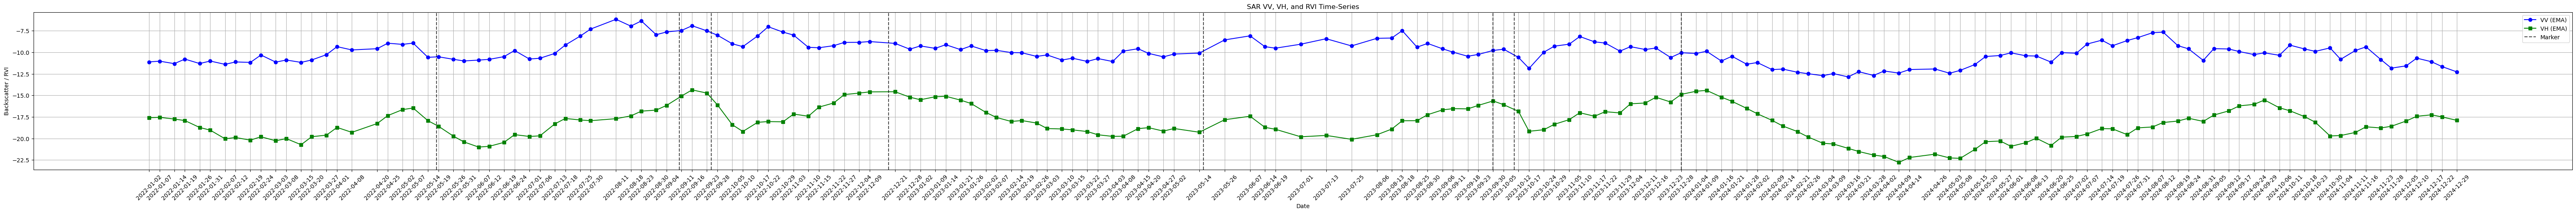

In [182]:
import pandas as pd
import matplotlib.pyplot as plt


df_farm41 = df
df_farm41["Date"] = pd.to_datetime(df_farm41["Date"])  # Convert Date column to datetime format

marker_dates = ["2022-05-18", "2022-09-10", "2022-09-25", "2022-12-18", "2023-05-16", "2023-09-30", "2023-10-10", "2023-12-28" ]  # Change this to any specific dates
marker_dates = pd.to_datetime(marker_dates)

span = 5  # Adjust span for more/less smoothing
df["VV_EMA"] = df_farm41["VV (dB)"].ewm(span=span, adjust=False).mean()
df["VH_EMA"] = df_farm41["VH (dB)"].ewm(span=span, adjust=False).mean()
#df["RVI_EMA"] = df_farm41["RVI"].ewm(span=span, adjust=False).mean()

# Plot VV, VH, and RVI over time
plt.figure(figsize=(80, 5))
#plt.plot(df["Date"], df["VV (dB)"], marker='o', linestyle='-', label="VV", color="blue")
#plt.plot(df["Date"], df["VH (dB)"], marker='s', linestyle='-', label="VH", color="green")
#plt.plot(df["Date"], df["RVI"], marker='d', linestyle='-', label="RVI", color="red")


plt.plot(df_farm41["Date"], df_farm41["VV_EMA"], marker='o', linestyle='-', label="VV (EMA)", color="blue")
plt.plot(df_farm41["Date"], df_farm41["VH_EMA"], marker='s', linestyle='-', label="VH (EMA)", color="green")
#plt.plot(df_farm41["Date"], df_farm41["RVI_EMA"], marker='d', linestyle='-', label="RVI (EMA)", color="red")

#Add Vertical Markers
for date in marker_dates:
    plt.axvline(x=date, color="black", linestyle="--", alpha=0.7, label="Marker" if date == marker_dates[0] else "")
    
plt.xlabel("Date")
plt.ylabel("Backscatter / RVI")
plt.title("SAR VV, VH, and RVI Time-Series")
plt.legend()


# Set all x-axis dates as labels
plt.xticks(df["Date"], df["Date"].dt.strftime('%Y-%m-%d'), rotation=45)

plt.grid(True)
plt.show()

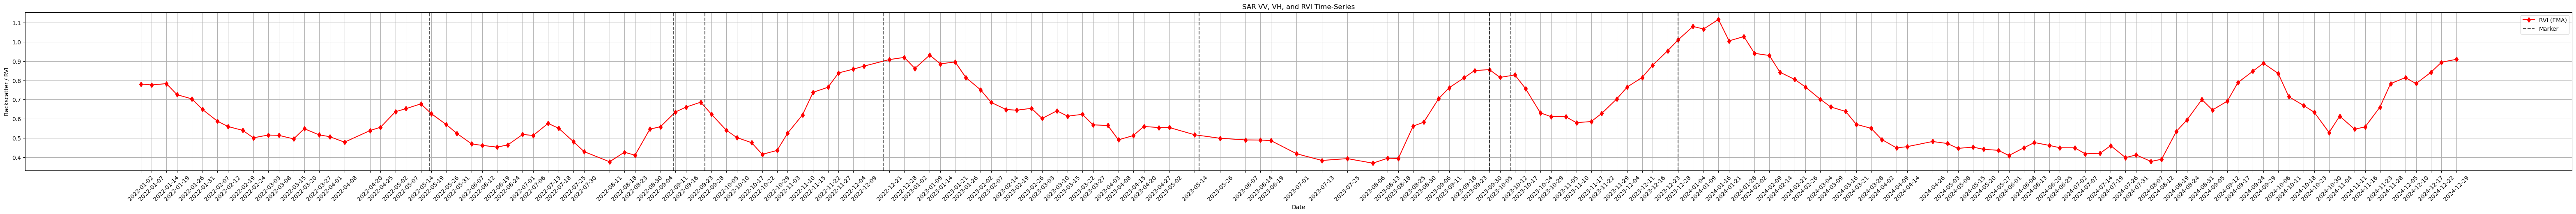

In [184]:
import pandas as pd
import matplotlib.pyplot as plt


df_farm41 = df
df_farm41["Date"] = pd.to_datetime(df_farm41["Date"])  # Convert Date column to datetime format

marker_dates = ["2022-05-18", "2022-09-10", "2022-09-25", "2022-12-18", "2023-05-16", "2023-09-30", "2023-10-10", "2023-12-28" ]  # Change this to any specific dates
marker_dates = pd.to_datetime(marker_dates)

span = 7  # Adjust span for more/less smoothing
#df["VV_EMA"] = df_farm41["VV (dB)"].ewm(span=span, adjust=False).mean()
#df["VH_EMA"] = df_farm41["VH (dB)"].ewm(span=span, adjust=False).mean()
df["RVI_EMA"] = df_farm41["RVI"].ewm(span=span, adjust=False).mean()

# Plot VV, VH, and RVI over time
plt.figure(figsize=(80, 5))
#plt.plot(df["Date"], df["VV (dB)"], marker='o', linestyle='-', label="VV", color="blue")
#plt.plot(df["Date"], df["VH (dB)"], marker='s', linestyle='-', label="VH", color="green")
#plt.plot(df["Date"], df["RVI"], marker='d', linestyle='-', label="RVI", color="red")


#plt.plot(df_farm41["Date"], df_farm41["VV_EMA"], marker='o', linestyle='-', label="VV (EMA)", color="blue")
#plt.plot(df_farm41["Date"], df_farm41["VH_EMA"], marker='s', linestyle='-', label="VH (EMA)", color="green")
plt.plot(df_farm41["Date"], df_farm41["RVI_EMA"], marker='d', linestyle='-', label="RVI (EMA)", color="red")

#Add Vertical Markers
for date in marker_dates:
    plt.axvline(x=date, color="black", linestyle="--", alpha=0.7, label="Marker" if date == marker_dates[0] else "")
    
plt.xlabel("Date")
plt.ylabel("Backscatter / RVI")
plt.title("SAR VV, VH, and RVI Time-Series")
plt.legend()


# Set all x-axis dates as labels
plt.xticks(df["Date"], df["Date"].dt.strftime('%Y-%m-%d'), rotation=45)

plt.grid(True)
plt.show()

In [8]:
import json
import ee
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
import os

def get_rvi_time_series(farmid, polygon, start_date, end_date):
    """
    Computes the Radar Vegetation Index (RVI) time-series from Sentinel-1 SAR images.
    
    Parameters:
    - df: Input DataFrame (not used in the function but kept for consistency)
    - polygon: AOI (Area of Interest) as an ee.Geometry.Polygon
    - start_date: Start date in 'YYYY-MM-DD' format
    - end_date: End date in 'YYYY-MM-DD' format

    Returns:
    - df_rvi: DataFrame containing RVI time-series
    """
    # Define the AOI (Agricultural Area of Interest)
    polygon = ee.Geometry.Polygon([
        [
            [103.263812885029, 12.9736877005695],
            [103.263483208572, 12.9736281025561],
            [103.263080930871, 12.9735726112348],
            [103.263049849315, 12.9739076801196],
            [103.263035383039, 12.9740636305649],
            [103.263006915991, 12.9742861431605],
            [103.263274716979, 12.9743223697405],
            [103.263522556166, 12.9743676464221],
            [103.263536641774, 12.9743620006856],
            [103.263689855308, 12.9743802426528],
            [103.263725225172, 12.9741749952689],
            [103.263783590784, 12.9738608458718],
            [103.263812885029, 12.9736877005695]  # Closing the polygon
        ]
    ])
    
    # Load Sentinel-1 SAR Collection (Selecting VV and VH bands only)
    sar_collection = (
        ee.ImageCollection("COPERNICUS/S1_GRD")
        .filterBounds(polygon)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
        .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VH"))
        .filter(ee.Filter.eq("instrumentMode", "IW"))
        .filter(ee.Filter.eq("orbitProperties_pass", "DESCENDING"))  # Use descending pass for consistency
        .select(["VV", "VH"])  # Explicitly selecting required bands
    )

    # Convert Sentinel-1 from dB to linear scale and retain time properties
    def to_linear(image):
        """Convert Sentinel-1 SAR backscatter from dB to linear scale, preserving metadata"""
        linear = image.expression("10**(b0/10)", {'b0': image})
        return linear.rename(["VV", "VH"]).copyProperties(image, ["system:time_start"])

    sar_collection = sar_collection.map(to_linear)

    # Apply a refined Lee Speckle Filter and retain time properties
    def refined_lee_filter(img):
        """Applies a refined Lee speckle filter with a 5x5 kernel to reduce noise."""
        def filter_band(band):
            b = img.select(band)
            KERNEL_SIZE = 5  # Stronger filtering
            mean = b.reduceNeighborhood(ee.Reducer.mean(), ee.Kernel.square(KERNEL_SIZE / 2))
            variance = b.reduceNeighborhood(ee.Reducer.variance(), ee.Kernel.square(KERNEL_SIZE / 2))
            var_term = variance.divide(variance.add(mean.multiply(mean)))
            filtered = mean.add(var_term.multiply(b.subtract(mean)))
            return filtered.rename([band])

        return ee.Image.cat([filter_band("VV"), filter_band("VH")]).copyProperties(img, ['system:time_start'])

    # Apply the filter to the collection
    sar_filtered = sar_collection.map(refined_lee_filter)

    # Compute the Corrected Radar Vegetation Index (RVI) and retain time properties
    def compute_rvi(image):
        """Corrected RVI calculation for Sentinel-1 dual-pol data with VV threshold."""
        vv = image.select("VV").max(0.001)  # Prevent division by near-zero values
        vh = image.select("VH")
        rvi = vh.divide(vv.add(vh)).rename(["RVI"])
        return image.addBands(rvi).copyProperties(image, ["system:time_start"])

    # Apply RVI computation
    sar_rvi = sar_filtered.map(compute_rvi)

    # Extract RVI values per Sentinel-1 pass
    def extract_rvi(image):
        """Extracts RVI value for each Sentinel-1 image."""
        rvi_value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=polygon,
            scale=10,
            maxPixels=1e13
        )
        return ee.Feature(None, {
            'date': ee.Date(image.get("system:time_start")).format("YYYY-MM-dd"),
            'RVI': rvi_value.get("RVI")
        })

    # Map function over the collection
    rvi_time_series = sar_rvi.map(extract_rvi).aggregate_array("date").getInfo()
    rvi_values = sar_rvi.map(extract_rvi).aggregate_array("RVI").getInfo()

    # Convert to DataFrame
    df_rvi = pd.DataFrame({'Date': rvi_time_series, 'RVI': rvi_values})

    return df_rvi


In [15]:
print(df)

          Date       RVI
0   2022-01-02  0.193451
1   2022-01-07  0.186643
2   2022-01-14  0.190830
3   2022-01-19  0.126011
4   2022-01-26  0.145020
5   2022-01-31  0.117606
6   2022-02-07  0.099151
7   2022-02-12  0.109524
8   2022-02-19  0.112823
9   2022-02-24  0.088023
10  2022-03-03  0.134610
11  2022-03-08  0.124126
12  2022-03-15  0.096440
13  2022-03-20  0.156468
14  2022-03-27  0.099098


In [6]:
import pandas as pd

# Load the CSV file
file_path = "output_with_WKT.csv"  # Replace with the actual file path
df = pd.read_csv(file_path)


# Convert 'Sowing Date' and 'Harvest Date' to datetime format
df["Sowing Date"] = pd.to_datetime(df["Sowing Date"], format="%Y-%m-%d", errors="coerce")
df["Harvest Date"] = pd.to_datetime(df["Harvest Date"], format="%Y-%m-%d", errors="coerce")

# Display the first few rows to verify the changes
print(df.head())



    Cycle Plot No  FarmID   No    Block        Method       Variety  \
0  2022-1    AEA1    2916    1      NaN       Long CC  Srangae Sral   
1  2022-2    AEA1    2916    1      NaN       Long CC  Srangae Sral   
2  2022-1   AEA10    2917   10      NaN  Conventional  Srangae Sral   
3  2022-2   AEA10    2917   10      NaN  Conventional  Srangae Sral   
4  2023-1  AEA100    2918  100  Block E      Mungbean  Srangae sral   

   Surface (ha)  Seed Quantity (kg)  Basal Fertilizer Applied?  ...  \
0          0.40                64.0                        0.0  ...   
1          0.40                64.0                        0.0  ...   
2          0.30                48.0                        0.0  ...   
3          0.30                48.0                        0.0  ...   
4          0.51                91.8                        0.0  ...   

   Number of Mollucide Applied  Number of Insecticide Applied  \
0                          0.0                              0   
1               

In [8]:
import ee
import pandas as pd
from shapely import wkt

# Define the maximum number of RVI columns to add
max_rvi_columns = 40

# Create new RVI column names
rvi_columns = [f"RVI_{i+1}" for i in range(max_rvi_columns)]

start_date = '2022-01-01'
end_date = '2025-01-01'


# Initialize RVI columns in the original df
for col in rvi_columns:
    df[col] = None  # Fill with None initially

def get_polygon_from_df(row):
    """
    Extracts the polygon from a DataFrame row and converts it to an EE Geometry.

    Parameters:
    - row: A row from the DataFrame containing 'polygon_wkt'

    Returns:
    - ee.Geometry.Polygon object
    """
    polygon_wkt = row["polygon_wkt"]  # Extract the WKT string
    shapely_polygon = wkt.loads(polygon_wkt)  # Convert WKT to Shapely polygon
    coords = list(shapely_polygon.exterior.coords)  # Extract coordinates as a list

    return ee.Geometry.Polygon(coords)  # Convert to EE Geometry

# Iterate through each row in the DataFrame 
for index, row in df.iterrows():
    
    polygon = get_polygon_from_df(row)  # Convert polygon WKT to EE Geometry
    #start_date = row["Sowing Date"]
    #end_date = row["Harvest Date"]
    #print(polygon)
    #print(start_date)
    #print(end_date)

    # Call the function for the current farm
    df_rvi = get_rvi_time_series(polygon, start_date, end_date)
    df_rvi = df_rvi.sort_values(by="Date", ascending=False)


    # Extract RVI values as a list
    rvi_values = df_rvi["RVI"].tolist()

    # Ensure there are exactly x columns (fill with None if fewer)
    rvi_values += [None] * (max_rvi_columns - len(rvi_values))  # Pad with None if needed

    # Assign RVI values to the corresponding row in df
    for j in range(max_rvi_columns):
        df.at[index, f"RVI_t-_{j+1}"] = rvi_values[j]
    
    # Print or process the results as needed
    #print(df_rvi)

    # Print progress every 10 rows
    if index % 10 == 0:
        print(f"Processed {index+1}/{len(df)} rows.")

    


Processed 1/260 rows.
Processed 11/260 rows.
Processed 21/260 rows.
Processed 31/260 rows.
Processed 41/260 rows.
Processed 51/260 rows.
Processed 61/260 rows.
Processed 71/260 rows.
Processed 81/260 rows.
Processed 91/260 rows.
Processed 101/260 rows.
Processed 111/260 rows.
Processed 121/260 rows.
Processed 131/260 rows.
Processed 141/260 rows.
Processed 151/260 rows.
Processed 161/260 rows.
Processed 171/260 rows.
Processed 181/260 rows.
Processed 191/260 rows.
Processed 201/260 rows.
Processed 211/260 rows.
Processed 221/260 rows.
Processed 231/260 rows.
Processed 241/260 rows.
Processed 251/260 rows.


In [9]:
# Show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Print the entire DataFrame
print(df)

      Cycle Plot No  FarmID   No    Block        Method       Variety  \
0    2022-1    AEA1    2916    1      NaN       Long CC  Srangae Sral   
1    2022-2    AEA1    2916    1      NaN       Long CC  Srangae Sral   
2    2022-1   AEA10    2917   10      NaN  Conventional  Srangae Sral   
3    2022-2   AEA10    2917   10      NaN  Conventional  Srangae Sral   
4    2023-1  AEA100    2918  100  Block E      Mungbean  Srangae sral   
5    2023-1  AEA101    2919  101  Block B        LongCC     Sen Kraob   
6    2023-2  AEA101    2919  101  Block B        LongCC  Srangae sral   
7    2023-3  AEA101    2919  101      NaN        LongCC  Srangae sral   
8    2023-1  AEA102    2920  102  Block D      Mungbean  Srangae sral   
9    2023-2  AEA102    2920  102  Block D      Mungbean           NaN   
10   2023-1  AEA103    2921  103  Block A        LongCC     Sen Kraob   
11   2023-2  AEA103    2921  103  Block A        LongCC  Srangae sral   
12   2023-3  AEA103    2921  103      NaN        Lo

In [10]:
df.to_csv("full_dataframe_with RVI_mean.csv", index=False)
print("Saved to full_dataframe.csv")

Saved to full_dataframe.csv
